In [1]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

c:\Users\cheng\Workspace\robinhood_classifer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ML Pipeline Flow

In [2]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [3]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


In [4]:
'''
This pipeline includes the following:

Data Preprocessing: Label encoding, scaling, and feature engineering.
Handling Imbalance: Using SMOTE for oversampling the minority class.
Modeling and Hyperparameter Tuning: Using Optuna to tune the hyperparameters of models like XGBoost, LightGBM, RandomForest, and Logistic Regression.
Evaluation: Automatically selecting the best model with the highest AUC score.
Explainability: Using SHAP to interpret the model.'''

'\nThis pipeline includes the following:\n\nData Preprocessing: Label encoding, scaling, and feature engineering.\nHandling Imbalance: Using SMOTE for oversampling the minority class.\nModeling and Hyperparameter Tuning: Using Optuna to tune the hyperparameters of models like XGBoost, LightGBM, RandomForest, and Logistic Regression.\nEvaluation: Automatically selecting the best model with the highest AUC score.\nExplainability: Using SHAP to interpret the model.'

### Step 1: Data Preprocessing and Feature Engineering

In [5]:
# Label encoding for categorical variables
label_enc = LabelEncoder()
df['risk_tolerance'] = label_enc.fit_transform(df['risk_tolerance'])
df['investment_experience'] = label_enc.fit_transform(df['investment_experience'])
df['liquidity_needs'] = label_enc.fit_transform(df['liquidity_needs'])
df['platform'] = label_enc.fit_transform(df['platform'])
df['time_horizon'] = label_enc.fit_transform(df['time_horizon'])

# Scaling the numerical features
scaler = StandardScaler()
df[['time_spent', 'first_deposit_amount']] = scaler.fit_transform(df[['time_spent', 'first_deposit_amount']])

# Feature Engineering: Additional features
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)  # Avoid division by zero
df['is_high_risk'] = (df['risk_tolerance'] == 0).astype(int)  # Assuming 0 = high risk


# Split the dataset into features and target
X = df.drop(columns=['user_id', 'churn_flag'])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

y = df['churn_flag']

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_original = X  # Store the original feature matrix
y_original = y  # Store the original target variable
X_resampled, y_resampled = smote.fit_resample(X_original, y_original)


### Step 2: Model Definition and Objective Function for Optuna

In [6]:
# Define the models: XGBoost, LightGBM, RandomForest, and Logistic Regression
# Optuna will optimize each model's hyperparameters.
# Now proceed with Optuna's hyperparameter tuning on resampled data


def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['xgboost', 'lightgbm', 'randomforest', 'logistic'])

    if model_type == 'xgboost':
        model = xgb.XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            subsample=trial.suggest_float('subsample', 0.6, 1.0)
        )

    elif model_type == 'lightgbm':
        model = lgb.LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 20, 150),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            feature_fraction=trial.suggest_float('feature_fraction', 0.6, 1.0)
        )

    elif model_type == 'randomforest':
        model = RandomForestClassifier(
            max_depth=trial.suggest_int('max_depth', 3, 10),
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        )

    elif model_type == 'logistic':
        model = LogisticRegression(
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            C=trial.suggest_float('C', 0.01, 10, log=True),
            solver='liblinear'
        )

    # Train-Test split (using resampled data for training)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate AUC score
    auc = roc_auc_score(y_test, y_pred)

    return auc


### Step 3: Running Optuna for Hyperparameter Tuning

In [7]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial and parameters
print(f"Best Trial: {study.best_trial}")
print(f"Best Parameters: {study.best_params}")

[I 2024-10-03 19:39:41,269] A new study created in memory with name: no-name-7096cb01-f149-429f-947c-8999adbbf40c
[I 2024-10-03 19:39:42,095] Trial 0 finished with value: 0.8886710280093304 and parameters: {'model_type': 'xgboost', 'max_depth': 6, 'learning_rate': 0.13409111020653708, 'n_estimators': 277, 'subsample': 0.8579303014751296}. Best is trial 0 with value: 0.8886710280093304.
[I 2024-10-03 19:39:42,193] Trial 1 finished with value: 0.6437339401929428 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.48122297109888296}. Best is trial 0 with value: 0.8886710280093304.
[I 2024-10-03 19:39:42,242] Trial 2 finished with value: 0.6443986473623804 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.4153146883459053}. Best is trial 0 with value: 0.8886710280093304.
[I 2024-10-03 19:39:42,705] Trial 3 finished with value: 0.8685759784386846 and parameters: {'model_type': 'xgboost', 'max_depth': 3, 'learning_rate': 0.15945606372523824, 'n_estimators': 26

[LightGBM] [Warning] feature_fraction is set=0.8303385495929851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303385495929851
[LightGBM] [Warning] feature_fraction is set=0.8303385495929851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303385495929851
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:39:44,764] Trial 6 finished with value: 0.9184979355767233 and parameters: {'model_type': 'lightgbm', 'num_leaves': 78, 'learning_rate': 0.03961012458334344, 'n_estimators': 237, 'feature_fraction': 0.8303385495929851}. Best is trial 6 with value: 0.9184979355767233.


[LightGBM] [Warning] feature_fraction is set=0.8303385495929851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303385495929851


[I 2024-10-03 19:39:45,190] Trial 7 finished with value: 0.8949808091970513 and parameters: {'model_type': 'xgboost', 'max_depth': 7, 'learning_rate': 0.10383410120136374, 'n_estimators': 239, 'subsample': 0.9224977882633283}. Best is trial 6 with value: 0.9184979355767233.
[I 2024-10-03 19:39:45,637] Trial 8 finished with value: 0.8039571996514929 and parameters: {'model_type': 'randomforest', 'max_depth': 9, 'n_estimators': 52, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9184979355767233.
[I 2024-10-03 19:39:45,788] Trial 9 finished with value: 0.8743174211731548 and parameters: {'model_type': 'xgboost', 'max_depth': 4, 'learning_rate': 0.26406623703836696, 'n_estimators': 77, 'subsample': 0.9619432228288525}. Best is trial 6 with value: 0.9184979355767233.


[LightGBM] [Warning] feature_fraction is set=0.8301858974549979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8301858974549979
[LightGBM] [Warning] feature_fraction is set=0.8301858974549979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8301858974549979
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:39:46,555] Trial 10 finished with value: 0.8967893024405772 and parameters: {'model_type': 'lightgbm', 'num_leaves': 77, 'learning_rate': 0.01332703554665121, 'n_estimators': 192, 'feature_fraction': 0.8301858974549979}. Best is trial 6 with value: 0.9184979355767233.


[LightGBM] [Warning] feature_fraction is set=0.8301858974549979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8301858974549979
[LightGBM] [Warning] feature_fraction is set=0.8384454293452229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384454293452229
[LightGBM] [Warning] feature_fraction is set=0.8384454293452229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384454293452229
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:39:47,510] Trial 11 finished with value: 0.8945712421532563 and parameters: {'model_type': 'lightgbm', 'num_leaves': 73, 'learning_rate': 0.013659899834061627, 'n_estimators': 200, 'feature_fraction': 0.8384454293452229}. Best is trial 6 with value: 0.9184979355767233.


[LightGBM] [Warning] feature_fraction is set=0.8384454293452229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8384454293452229
[LightGBM] [Warning] feature_fraction is set=0.8366819884980304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366819884980304
[LightGBM] [Warning] feature_fraction is set=0.8366819884980304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366819884980304
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:39:48,211] Trial 12 finished with value: 0.8876810764227616 and parameters: {'model_type': 'lightgbm', 'num_leaves': 77, 'learning_rate': 0.01468891169884297, 'n_estimators': 134, 'feature_fraction': 0.8366819884980304}. Best is trial 6 with value: 0.9184979355767233.


[LightGBM] [Warning] feature_fraction is set=0.8366819884980304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366819884980304
[LightGBM] [Warning] feature_fraction is set=0.676212568657566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.676212568657566
[LightGBM] [Warning] feature_fraction is set=0.676212568657566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.676212568657566
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 19:39:49,826] Trial 13 finished with value: 0.919446811972786 and parameters: {'model_type': 'lightgbm', 'num_leaves': 129, 'learning_rate': 0.031463935910914925, 'n_estimators': 214, 'feature_fraction': 0.676212568657566}. Best is trial 13 with value: 0.919446811972786.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.676212568657566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.676212568657566
[LightGBM] [Warning] feature_fraction is set=0.6087575593289208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087575593289208
[LightGBM] [Warning] feature_fraction is set=0.6087575593289208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087575593289208
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pa

[I 2024-10-03 19:39:51,819] Trial 14 finished with value: 0.9184738433976766 and parameters: {'model_type': 'lightgbm', 'num_leaves': 148, 'learning_rate': 0.03605573491882478, 'n_estimators': 233, 'feature_fraction': 0.6087575593289208}. Best is trial 13 with value: 0.919446811972786.


[LightGBM] [Warning] feature_fraction is set=0.6087575593289208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087575593289208
[LightGBM] [Warning] feature_fraction is set=0.6623516711357115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6623516711357115
[LightGBM] [Warning] feature_fraction is set=0.6623516711357115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6623516711357115
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:39:53,618] Trial 15 finished with value: 0.9182378585291447 and parameters: {'model_type': 'lightgbm', 'num_leaves': 138, 'learning_rate': 0.029412530743861805, 'n_estimators': 300, 'feature_fraction': 0.6623516711357115}. Best is trial 13 with value: 0.919446811972786.


[LightGBM] [Warning] feature_fraction is set=0.6623516711357115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6623516711357115
[LightGBM] [Warning] feature_fraction is set=0.7257444222810059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7257444222810059
[LightGBM] [Warning] feature_fraction is set=0.7257444222810059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7257444222810059
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:39:53,836] Trial 16 finished with value: 0.8876690303332382 and parameters: {'model_type': 'lightgbm', 'num_leaves': 27, 'learning_rate': 0.02946933249817863, 'n_estimators': 141, 'feature_fraction': 0.7257444222810059}. Best is trial 13 with value: 0.919446811972786.


[LightGBM] [Warning] feature_fraction is set=0.7257444222810059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7257444222810059
[LightGBM] [Warning] feature_fraction is set=0.981987455833938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981987455833938
[LightGBM] [Warning] feature_fraction is set=0.981987455833938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981987455833938
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 19:39:54,757] Trial 17 finished with value: 0.9245115014482954 and parameters: {'model_type': 'lightgbm', 'num_leaves': 113, 'learning_rate': 0.05917636719032032, 'n_estimators': 224, 'feature_fraction': 0.981987455833938}. Best is trial 17 with value: 0.9245115014482954.


[LightGBM] [Warning] feature_fraction is set=0.981987455833938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.981987455833938
[LightGBM] [Warning] feature_fraction is set=0.9666855712903819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9666855712903819
[LightGBM] [Warning] feature_fraction is set=0.9666855712903819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9666855712903819
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:39:55,508] Trial 18 finished with value: 0.9220092719343493 and parameters: {'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.07143565169695497, 'n_estimators': 144, 'feature_fraction': 0.9666855712903819}. Best is trial 17 with value: 0.9245115014482954.


[LightGBM] [Warning] feature_fraction is set=0.9666855712903819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9666855712903819


[I 2024-10-03 19:39:56,837] Trial 19 finished with value: 0.6386884059745446 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 9.84355914814636}. Best is trial 17 with value: 0.9245115014482954.
[I 2024-10-03 19:40:00,186] Trial 20 finished with value: 0.8315873744343274 and parameters: {'model_type': 'randomforest', 'max_depth': 8, 'n_estimators': 136, 'max_features': None}. Best is trial 17 with value: 0.9245115014482954.


[LightGBM] [Warning] feature_fraction is set=0.9988096456045615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988096456045615
[LightGBM] [Warning] feature_fraction is set=0.9988096456045615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988096456045615
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:01,165] Trial 21 finished with value: 0.9210844877173332 and parameters: {'model_type': 'lightgbm', 'num_leaves': 117, 'learning_rate': 0.07049758445482794, 'n_estimators': 213, 'feature_fraction': 0.9988096456045615}. Best is trial 17 with value: 0.9245115014482954.


[LightGBM] [Warning] feature_fraction is set=0.9988096456045615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9988096456045615
[LightGBM] [Warning] feature_fraction is set=0.9783335273782612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783335273782612
[LightGBM] [Warning] feature_fraction is set=0.9783335273782612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783335273782612
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:01,827] Trial 22 finished with value: 0.9254724239338815 and parameters: {'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.0703822065161471, 'n_estimators': 156, 'feature_fraction': 0.9783335273782612}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9783335273782612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783335273782612
[LightGBM] [Warning] feature_fraction is set=0.9890398522435284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9890398522435284
[LightGBM] [Warning] feature_fraction is set=0.9890398522435284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9890398522435284
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:02,481] Trial 23 finished with value: 0.9220815484714895 and parameters: {'model_type': 'lightgbm', 'num_leaves': 109, 'learning_rate': 0.07989144645568196, 'n_estimators': 158, 'feature_fraction': 0.9890398522435284}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9890398522435284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9890398522435284
[LightGBM] [Warning] feature_fraction is set=0.9328342638141515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9328342638141515
[LightGBM] [Warning] feature_fraction is set=0.9328342638141515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9328342638141515
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:02,938] Trial 24 finished with value: 0.9204197805478955 and parameters: {'model_type': 'lightgbm', 'num_leaves': 104, 'learning_rate': 0.09696714211074944, 'n_estimators': 116, 'feature_fraction': 0.9328342638141515}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9328342638141515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9328342638141515
[LightGBM] [Warning] feature_fraction is set=0.9056943168535248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056943168535248
[LightGBM] [Warning] feature_fraction is set=0.9056943168535248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056943168535248
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:03,554] Trial 25 finished with value: 0.9188423352509654 and parameters: {'model_type': 'lightgbm', 'num_leaves': 100, 'learning_rate': 0.045575446736058435, 'n_estimators': 162, 'feature_fraction': 0.9056943168535248}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9056943168535248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056943168535248
[LightGBM] [Warning] feature_fraction is set=0.9113712313400958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9113712313400958
[LightGBM] [Warning] feature_fraction is set=0.9113712313400958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9113712313400958
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:03,951] Trial 26 finished with value: 0.9226137486561699 and parameters: {'model_type': 'lightgbm', 'num_leaves': 96, 'learning_rate': 0.08951414750845955, 'n_estimators': 102, 'feature_fraction': 0.9113712313400958}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9113712313400958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9113712313400958
[LightGBM] [Warning] feature_fraction is set=0.9080770032476557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9080770032476557
[LightGBM] [Warning] feature_fraction is set=0.9080770032476557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9080770032476557
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:04,305] Trial 27 finished with value: 0.9167688280379251 and parameters: {'model_type': 'lightgbm', 'num_leaves': 94, 'learning_rate': 0.19712638034421268, 'n_estimators': 100, 'feature_fraction': 0.9080770032476557}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9080770032476557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9080770032476557


[I 2024-10-03 19:40:05,689] Trial 28 finished with value: 0.6647818156972001 and parameters: {'model_type': 'randomforest', 'max_depth': 3, 'n_estimators': 103, 'max_features': None}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:05,732] Trial 29 finished with value: 0.5927256627521483 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.01308705541193937}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.941819548599848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941819548599848
[LightGBM] [Warning] feature_fraction is set=0.941819548599848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941819548599848
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:06,162] Trial 30 finished with value: 0.9129924777107848 and parameters: {'model_type': 'lightgbm', 'num_leaves': 48, 'learning_rate': 0.055162874528217797, 'n_estimators': 181, 'feature_fraction': 0.941819548599848}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.941819548599848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941819548599848
[LightGBM] [Warning] feature_fraction is set=0.9951846918737581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9951846918737581
[LightGBM] [Warning] feature_fraction is set=0.9951846918737581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9951846918737581
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:40:06,793] Trial 31 finished with value: 0.9235144406941391 and parameters: {'model_type': 'lightgbm', 'num_leaves': 118, 'learning_rate': 0.09450244811343084, 'n_estimators': 160, 'feature_fraction': 0.9951846918737581}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9951846918737581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9951846918737581
[LightGBM] [Warning] feature_fraction is set=0.9576598729233207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9576598729233207
[LightGBM] [Warning] feature_fraction is set=0.9576598729233207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9576598729233207
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:07,372] Trial 32 finished with value: 0.9210844877173332 and parameters: {'model_type': 'lightgbm', 'num_leaves': 125, 'learning_rate': 0.11220684697243101, 'n_estimators': 116, 'feature_fraction': 0.9576598729233207}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9576598729233207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9576598729233207
[LightGBM] [Warning] feature_fraction is set=0.8950498828635639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950498828635639
[LightGBM] [Warning] feature_fraction is set=0.8950498828635639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950498828635639
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:07,887] Trial 33 finished with value: 0.92264988692474 and parameters: {'model_type': 'lightgbm', 'num_leaves': 91, 'learning_rate': 0.08791454951973854, 'n_estimators': 161, 'feature_fraction': 0.8950498828635639}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:07,937] Trial 34 finished with value: 0.5872804353338268 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 0.010903808966794493}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8950498828635639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8950498828635639
[LightGBM] [Warning] feature_fraction is set=0.8900777157795375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8900777157795375
[LightGBM] [Warning] feature_fraction is set=0.8900777157795375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8900777157795375
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:08,636] Trial 35 finished with value: 0.9201958417688874 and parameters: {'model_type': 'lightgbm', 'num_leaves': 128, 'learning_rate': 0.13389543748686109, 'n_estimators': 163, 'feature_fraction': 0.8900777157795375}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8900777157795375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8900777157795375


[I 2024-10-03 19:40:09,239] Trial 36 finished with value: 0.8999491299563736 and parameters: {'model_type': 'xgboost', 'max_depth': 10, 'learning_rate': 0.0501710434103253, 'n_estimators': 191, 'subsample': 0.6325306891482199}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.996094841005268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996094841005268
[LightGBM] [Warning] feature_fraction is set=0.996094841005268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996094841005268
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:10,316] Trial 37 finished with value: 0.9230304248675523 and parameters: {'model_type': 'lightgbm', 'num_leaves': 117, 'learning_rate': 0.06475941454430886, 'n_estimators': 262, 'feature_fraction': 0.996094841005268}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:10,387] Trial 38 finished with value: 0.6377756678470518 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 9.854608676890258}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.996094841005268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996094841005268


[I 2024-10-03 19:40:12,097] Trial 39 finished with value: 0.7395135828545836 and parameters: {'model_type': 'randomforest', 'max_depth': 6, 'n_estimators': 264, 'max_features': 'log2'}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:12,802] Trial 40 finished with value: 0.8820529854159377 and parameters: {'model_type': 'xgboost', 'max_depth': 8, 'learning_rate': 0.019320746669659394, 'n_estimators': 259, 'subsample': 0.7584472409131015}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9927134332610296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927134332610296
[LightGBM] [Warning] feature_fraction is set=0.9927134332610296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927134332610296
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:13,851] Trial 41 finished with value: 0.9210844877173332 and parameters: {'model_type': 'lightgbm', 'num_leaves': 117, 'learning_rate': 0.06555094330147744, 'n_estimators': 290, 'feature_fraction': 0.9927134332610296}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9927134332610296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9927134332610296
[LightGBM] [Warning] feature_fraction is set=0.9523191591651302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9523191591651302
[LightGBM] [Warning] feature_fraction is set=0.9523191591651302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9523191591651302
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:14,640] Trial 42 finished with value: 0.9223536716085914 and parameters: {'model_type': 'lightgbm', 'num_leaves': 91, 'learning_rate': 0.12876563234606186, 'n_estimators': 254, 'feature_fraction': 0.9523191591651302}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9523191591651302, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9523191591651302
[LightGBM] [Warning] feature_fraction is set=0.9731277249476458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731277249476458
[LightGBM] [Warning] feature_fraction is set=0.9731277249476458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731277249476458
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:15,766] Trial 43 finished with value: 0.9217491948867707 and parameters: {'model_type': 'lightgbm', 'num_leaves': 121, 'learning_rate': 0.08327313549926857, 'n_estimators': 280, 'feature_fraction': 0.9731277249476458}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9731277249476458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9731277249476458
[LightGBM] [Warning] feature_fraction is set=0.8733807919969944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8733807919969944
[LightGBM] [Warning] feature_fraction is set=0.8733807919969944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8733807919969944
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:16,559] Trial 44 finished with value: 0.9198875803632153 and parameters: {'model_type': 'lightgbm', 'num_leaves': 136, 'learning_rate': 0.17505244311830073, 'n_estimators': 173, 'feature_fraction': 0.8733807919969944}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8733807919969944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8733807919969944
[LightGBM] [Warning] feature_fraction is set=0.9955348268329033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9955348268329033
[LightGBM] [Warning] feature_fraction is set=0.9955348268329033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9955348268329033
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:17,371] Trial 45 finished with value: 0.9230063326885055 and parameters: {'model_type': 'lightgbm', 'num_leaves': 107, 'learning_rate': 0.05668835216967774, 'n_estimators': 220, 'feature_fraction': 0.9955348268329033}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9955348268329033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9955348268329033
[LightGBM] [Warning] feature_fraction is set=0.9962249505491358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962249505491358
[LightGBM] [Warning] feature_fraction is set=0.9962249505491358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962249505491358
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:18,094] Trial 46 finished with value: 0.9216889644391538 and parameters: {'model_type': 'lightgbm', 'num_leaves': 108, 'learning_rate': 0.055817485041727996, 'n_estimators': 224, 'feature_fraction': 0.9962249505491358}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9962249505491358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962249505491358
[LightGBM] [Warning] feature_fraction is set=0.9355436218355098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9355436218355098
[LightGBM] [Warning] feature_fraction is set=0.9355436218355098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9355436218355098
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:19,030] Trial 47 finished with value: 0.9239190708159981 and parameters: {'model_type': 'lightgbm', 'num_leaves': 109, 'learning_rate': 0.042142338324867246, 'n_estimators': 251, 'feature_fraction': 0.9355436218355098}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9355436218355098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9355436218355098


[I 2024-10-03 19:40:19,482] Trial 48 finished with value: 0.8628876569842439 and parameters: {'model_type': 'xgboost', 'max_depth': 5, 'learning_rate': 0.04081089262511107, 'n_estimators': 241, 'subsample': 0.9971051383358468}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9393273488036251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9393273488036251
[LightGBM] [Warning] feature_fraction is set=0.9393273488036251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9393273488036251
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:20,758] Trial 49 finished with value: 0.9225896564771231 and parameters: {'model_type': 'lightgbm', 'num_leaves': 137, 'learning_rate': 0.02428101909141882, 'n_estimators': 247, 'feature_fraction': 0.9393273488036251}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9393273488036251, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9393273488036251


[I 2024-10-03 19:40:22,904] Trial 50 finished with value: 0.788471852830752 and parameters: {'model_type': 'randomforest', 'max_depth': 8, 'n_estimators': 277, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9699450556658893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9699450556658893
[LightGBM] [Warning] feature_fraction is set=0.9699450556658893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9699450556658893
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:23,837] Trial 51 finished with value: 0.9245355936273421 and parameters: {'model_type': 'lightgbm', 'num_leaves': 109, 'learning_rate': 0.06205845313620065, 'n_estimators': 209, 'feature_fraction': 0.9699450556658893}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9699450556658893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9699450556658893
[LightGBM] [Warning] feature_fraction is set=0.9679163348928058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9679163348928058
[LightGBM] [Warning] feature_fraction is set=0.9679163348928058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9679163348928058
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:24,618] Trial 52 finished with value: 0.92264988692474 and parameters: {'model_type': 'lightgbm', 'num_leaves': 115, 'learning_rate': 0.047183021400856937, 'n_estimators': 205, 'feature_fraction': 0.9679163348928058}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9679163348928058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9679163348928058
[LightGBM] [Warning] feature_fraction is set=0.9701619937238845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9701619937238845
[LightGBM] [Warning] feature_fraction is set=0.9701619937238845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9701619937238845
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:25,628] Trial 53 finished with value: 0.9233145940941776 and parameters: {'model_type': 'lightgbm', 'num_leaves': 126, 'learning_rate': 0.06819681107925375, 'n_estimators': 229, 'feature_fraction': 0.9701619937238845}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9701619937238845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9701619937238845
[LightGBM] [Warning] feature_fraction is set=0.933195930003521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933195930003521
[LightGBM] [Warning] feature_fraction is set=0.933195930003521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933195930003521
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score

[I 2024-10-03 19:40:26,598] Trial 54 finished with value: 0.9204559188164658 and parameters: {'model_type': 'lightgbm', 'num_leaves': 128, 'learning_rate': 0.11669065883700439, 'n_estimators': 229, 'feature_fraction': 0.933195930003521}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.933195930003521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933195930003521
[LightGBM] [Warning] feature_fraction is set=0.9604732484819751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604732484819751
[LightGBM] [Warning] feature_fraction is set=0.9604732484819751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604732484819751
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:40:27,200] Trial 55 finished with value: 0.9229822405094587 and parameters: {'model_type': 'lightgbm', 'num_leaves': 84, 'learning_rate': 0.07338179422697565, 'n_estimators': 195, 'feature_fraction': 0.9604732484819751}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9604732484819751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604732484819751
[LightGBM] [Warning] feature_fraction is set=0.971685299559392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971685299559392
[LightGBM] [Warning] feature_fraction is set=0.971685299559392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971685299559392
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:27,995] Trial 56 finished with value: 0.9216648722601071 and parameters: {'model_type': 'lightgbm', 'num_leaves': 104, 'learning_rate': 0.03914628790755818, 'n_estimators': 209, 'feature_fraction': 0.971685299559392}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.971685299559392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971685299559392
[LightGBM] [Warning] feature_fraction is set=0.7525199682438544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525199682438544
[LightGBM] [Warning] feature_fraction is set=0.7525199682438544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525199682438544
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:40:28,763] Trial 57 finished with value: 0.9214047952125286 and parameters: {'model_type': 'lightgbm', 'num_leaves': 122, 'learning_rate': 0.09866275798966884, 'n_estimators': 182, 'feature_fraction': 0.7525199682438544}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7525199682438544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525199682438544
[LightGBM] [Warning] feature_fraction is set=0.9292460296529896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9292460296529896
[LightGBM] [Warning] feature_fraction is set=0.9292460296529896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9292460296529896
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 74

[I 2024-10-03 19:40:29,934] Trial 58 finished with value: 0.9213927491230053 and parameters: {'model_type': 'lightgbm', 'num_leaves': 142, 'learning_rate': 0.059184714772835545, 'n_estimators': 247, 'feature_fraction': 0.9292460296529896}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:29,997] Trial 59 finished with value: 0.6392836012831258 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.06386361179770712}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9292460296529896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9292460296529896
[LightGBM] [Warning] feature_fraction is set=0.8622414447445171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622414447445171
[LightGBM] [Warning] feature_fraction is set=0.8622414447445171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622414447445171
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:30,702] Trial 60 finished with value: 0.9207039497745207 and parameters: {'model_type': 'lightgbm', 'num_leaves': 133, 'learning_rate': 0.0352573407991999, 'n_estimators': 150, 'feature_fraction': 0.8622414447445171}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8622414447445171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622414447445171
[LightGBM] [Warning] feature_fraction is set=0.9777011415404083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777011415404083
[LightGBM] [Warning] feature_fraction is set=0.9777011415404083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777011415404083
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:31,730] Trial 61 finished with value: 0.9239311169055215 and parameters: {'model_type': 'lightgbm', 'num_leaves': 112, 'learning_rate': 0.06475779946620353, 'n_estimators': 274, 'feature_fraction': 0.9777011415404083}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9777011415404083, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9777011415404083
[LightGBM] [Warning] feature_fraction is set=0.9707954427568487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9707954427568487
[LightGBM] [Warning] feature_fraction is set=0.9707954427568487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9707954427568487
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:32,650] Trial 62 finished with value: 0.9239672551740917 and parameters: {'model_type': 'lightgbm', 'num_leaves': 111, 'learning_rate': 0.07747054442478449, 'n_estimators': 236, 'feature_fraction': 0.9707954427568487}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9707954427568487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9707954427568487
[LightGBM] [Warning] feature_fraction is set=0.9750252485774339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9750252485774339
[LightGBM] [Warning] feature_fraction is set=0.9750252485774339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9750252485774339
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:34,063] Trial 63 finished with value: 0.922341625519068 and parameters: {'model_type': 'lightgbm', 'num_leaves': 110, 'learning_rate': 0.07893586089640915, 'n_estimators': 274, 'feature_fraction': 0.9750252485774339}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9750252485774339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9750252485774339
[LightGBM] [Warning] feature_fraction is set=0.9450338219422126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450338219422126
[LightGBM] [Warning] feature_fraction is set=0.9450338219422126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450338219422126
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:34,753] Trial 64 finished with value: 0.9204077344583723 and parameters: {'model_type': 'lightgbm', 'num_leaves': 68, 'learning_rate': 0.04679058962823635, 'n_estimators': 241, 'feature_fraction': 0.9450338219422126}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9450338219422126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450338219422126
[LightGBM] [Warning] feature_fraction is set=0.9852539025939541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852539025939541
[LightGBM] [Warning] feature_fraction is set=0.9852539025939541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852539025939541
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:35,267] Trial 65 finished with value: 0.9194709041518329 and parameters: {'model_type': 'lightgbm', 'num_leaves': 102, 'learning_rate': 0.06163737081508075, 'n_estimators': 128, 'feature_fraction': 0.9852539025939541}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9852539025939541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9852539025939541
[LightGBM] [Warning] feature_fraction is set=0.7839408663074409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839408663074409
[LightGBM] [Warning] feature_fraction is set=0.7839408663074409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839408663074409
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:36,087] Trial 66 finished with value: 0.9251400703491628 and parameters: {'model_type': 'lightgbm', 'num_leaves': 112, 'learning_rate': 0.05095896783515668, 'n_estimators': 217, 'feature_fraction': 0.7839408663074409}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7839408663074409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839408663074409


[I 2024-10-03 19:40:37,343] Trial 67 finished with value: 0.6909309138992916 and parameters: {'model_type': 'randomforest', 'max_depth': 4, 'n_estimators': 216, 'max_features': 'log2'}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:38,112] Trial 68 finished with value: 0.8980754693432946 and parameters: {'model_type': 'xgboost', 'max_depth': 9, 'learning_rate': 0.04043939120135906, 'n_estimators': 252, 'subsample': 0.8519500866255184}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7959645723189352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959645723189352
[LightGBM] [Warning] feature_fraction is set=0.7959645723189352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959645723189352
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-10-03 19:40:39,014] Trial 69 finished with value: 0.9213807030334819 and parameters: {'model_type': 'lightgbm', 'num_leaves': 112, 'learning_rate': 0.05177943028515579, 'n_estimators': 234, 'feature_fraction': 0.7959645723189352}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7959645723189352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959645723189352
[LightGBM] [Warning] feature_fraction is set=0.7527163329929263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7527163329929263
[LightGBM] [Warning] feature_fraction is set=0.7527163329929263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7527163329929263
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:39,737] Trial 70 finished with value: 0.921296380406818 and parameters: {'model_type': 'lightgbm', 'num_leaves': 100, 'learning_rate': 0.03271343695971236, 'n_estimators': 200, 'feature_fraction': 0.7527163329929263}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7937909481309289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937909481309289
[LightGBM] [Warning] feature_fraction is set=0.7937909481309289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937909481309289
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:40,454] Trial 71 finished with value: 0.9245355936273421 and parameters: {'model_type': 'lightgbm', 'num_leaves': 119, 'learning_rate': 0.08000951852872007, 'n_estimators': 171, 'feature_fraction': 0.7937909481309289}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7937909481309289, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937909481309289
[LightGBM] [Warning] feature_fraction is set=0.8036270179426499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8036270179426499
[LightGBM] [Warning] feature_fraction is set=0.8036270179426499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8036270179426499
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: 

[I 2024-10-03 19:40:41,139] Trial 72 finished with value: 0.8921533352659737 and parameters: {'model_type': 'lightgbm', 'num_leaves': 111, 'learning_rate': 0.0105961216049471, 'n_estimators': 169, 'feature_fraction': 0.8036270179426499}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8036270179426499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8036270179426499
[LightGBM] [Warning] feature_fraction is set=0.807197065552394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807197065552394
[LightGBM] [Warning] feature_fraction is set=0.807197065552394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807197065552394
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:41,822] Trial 73 finished with value: 0.9207521341326145 and parameters: {'model_type': 'lightgbm', 'num_leaves': 99, 'learning_rate': 0.07384566949385285, 'n_estimators': 189, 'feature_fraction': 0.807197065552394}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.807197065552394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807197065552394
[LightGBM] [Warning] feature_fraction is set=0.7740893641046729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7740893641046729
[LightGBM] [Warning] feature_fraction is set=0.7740893641046729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7740893641046729
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:40:42,921] Trial 74 finished with value: 0.9226739791037867 and parameters: {'model_type': 'lightgbm', 'num_leaves': 122, 'learning_rate': 0.06236081006051685, 'n_estimators': 271, 'feature_fraction': 0.7740893641046729}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7740893641046729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7740893641046729
[LightGBM] [Warning] feature_fraction is set=0.8172829616137843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8172829616137843
[LightGBM] [Warning] feature_fraction is set=0.8172829616137843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8172829616137843
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:43,738] Trial 75 finished with value: 0.9226017025666465 and parameters: {'model_type': 'lightgbm', 'num_leaves': 107, 'learning_rate': 0.04297389658087222, 'n_estimators': 221, 'feature_fraction': 0.8172829616137843}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:44,270] Trial 76 finished with value: 0.6396613745496539 and parameters: {'model_type': 'logistic', 'penalty': 'l1', 'C': 1.8398179524131746}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.771704678786071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771704678786071
[LightGBM] [Warning] feature_fraction is set=0.771704678786071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771704678786071
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-10-03 19:40:45,489] Trial 77 finished with value: 0.920183795679364 and parameters: {'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.08222058413812913, 'n_estimators': 286, 'feature_fraction': 0.771704678786071}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.771704678786071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.771704678786071
[LightGBM] [Warning] feature_fraction is set=0.8467510010440278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8467510010440278
[LightGBM] [Warning] feature_fraction is set=0.8467510010440278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8467510010440278
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:40:46,295] Trial 78 finished with value: 0.9245115014482954 and parameters: {'model_type': 'lightgbm', 'num_leaves': 121, 'learning_rate': 0.052181505920193126, 'n_estimators': 205, 'feature_fraction': 0.8467510010440278}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8467510010440278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8467510010440278
[LightGBM] [Warning] feature_fraction is set=0.6844580772157094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6844580772157094
[LightGBM] [Warning] feature_fraction is set=0.6844580772157094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6844580772157094
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:47,185] Trial 79 finished with value: 0.9191746888356842 and parameters: {'model_type': 'lightgbm', 'num_leaves': 132, 'learning_rate': 0.053239721204497645, 'n_estimators': 201, 'feature_fraction': 0.6844580772157094}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.6844580772157094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6844580772157094
[LightGBM] [Warning] feature_fraction is set=0.8452167671717611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8452167671717611
[LightGBM] [Warning] feature_fraction is set=0.8452167671717611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8452167671717611
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:47,979] Trial 80 finished with value: 0.9242152861321467 and parameters: {'model_type': 'lightgbm', 'num_leaves': 120, 'learning_rate': 0.0723755958922018, 'n_estimators': 184, 'feature_fraction': 0.8452167671717611}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8452167671717611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8452167671717611
[LightGBM] [Warning] feature_fraction is set=0.8460124178743368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8460124178743368
[LightGBM] [Warning] feature_fraction is set=0.8460124178743368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8460124178743368
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:48,764] Trial 81 finished with value: 0.9223295794295445 and parameters: {'model_type': 'lightgbm', 'num_leaves': 121, 'learning_rate': 0.07042514652691559, 'n_estimators': 186, 'feature_fraction': 0.8460124178743368}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8460124178743368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8460124178743368
[LightGBM] [Warning] feature_fraction is set=0.8283061335424536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8283061335424536
[LightGBM] [Warning] feature_fraction is set=0.8283061335424536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8283061335424536
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:49,589] Trial 82 finished with value: 0.9214409334810987 and parameters: {'model_type': 'lightgbm', 'num_leaves': 118, 'learning_rate': 0.10812327668937094, 'n_estimators': 211, 'feature_fraction': 0.8283061335424536}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8283061335424536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8283061335424536
[LightGBM] [Warning] feature_fraction is set=0.7781353541751261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7781353541751261
[LightGBM] [Warning] feature_fraction is set=0.7781353541751261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7781353541751261
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:50,314] Trial 83 finished with value: 0.9207159958640443 and parameters: {'model_type': 'lightgbm', 'num_leaves': 124, 'learning_rate': 0.09244625548786732, 'n_estimators': 176, 'feature_fraction': 0.7781353541751261}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7781353541751261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7781353541751261
[LightGBM] [Warning] feature_fraction is set=0.850023841426731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.850023841426731
[LightGBM] [Warning] feature_fraction is set=0.850023841426731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.850023841426731
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromS

[I 2024-10-03 19:40:50,511] Trial 84 finished with value: 0.8961245952711397 and parameters: {'model_type': 'lightgbm', 'num_leaves': 21, 'learning_rate': 0.07623372318031267, 'n_estimators': 151, 'feature_fraction': 0.850023841426731}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.850023841426731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.850023841426731


[I 2024-10-03 19:40:54,689] Trial 85 finished with value: 0.8298582668955292 and parameters: {'model_type': 'randomforest', 'max_depth': 7, 'n_estimators': 193, 'max_features': None}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:40:55,126] Trial 86 finished with value: 0.8771158660032498 and parameters: {'model_type': 'xgboost', 'max_depth': 5, 'learning_rate': 0.06454804844279949, 'n_estimators': 206, 'subsample': 0.7267836075284664}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7914350524416515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7914350524416515
[LightGBM] [Warning] feature_fraction is set=0.7914350524416515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7914350524416515
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:40:55,777] Trial 87 finished with value: 0.9226017025666465 and parameters: {'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.05085835139827896, 'n_estimators': 169, 'feature_fraction': 0.7914350524416515}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7914350524416515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7914350524416515
[LightGBM] [Warning] feature_fraction is set=0.725874163227757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.725874163227757
[LightGBM] [Warning] feature_fraction is set=0.725874163227757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.725874163227757
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg

[I 2024-10-03 19:40:56,485] Trial 88 finished with value: 0.9241911939531 and parameters: {'model_type': 'lightgbm', 'num_leaves': 105, 'learning_rate': 0.08639204668071451, 'n_estimators': 214, 'feature_fraction': 0.725874163227757}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.725874163227757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.725874163227757
[LightGBM] [Warning] feature_fraction is set=0.6797803029643364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797803029643364
[LightGBM] [Warning] feature_fraction is set=0.6797803029643364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797803029643364
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from sco

[I 2024-10-03 19:40:57,284] Trial 89 finished with value: 0.9213807030334819 and parameters: {'model_type': 'lightgbm', 'num_leaves': 104, 'learning_rate': 0.09032031840517857, 'n_estimators': 225, 'feature_fraction': 0.6797803029643364}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.6797803029643364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797803029643364
[LightGBM] [Warning] feature_fraction is set=0.7116270790418637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7116270790418637
[LightGBM] [Warning] feature_fraction is set=0.7116270790418637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7116270790418637
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:57,941] Trial 90 finished with value: 0.9229461022408886 and parameters: {'model_type': 'lightgbm', 'num_leaves': 97, 'learning_rate': 0.05868768047613371, 'n_estimators': 216, 'feature_fraction': 0.7116270790418637}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7116270790418637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7116270790418637
[LightGBM] [Warning] feature_fraction is set=0.6536852740825558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536852740825558
[LightGBM] [Warning] feature_fraction is set=0.6536852740825558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536852740825558
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:40:58,731] Trial 91 finished with value: 0.9203595501002787 and parameters: {'model_type': 'lightgbm', 'num_leaves': 119, 'learning_rate': 0.08529670916679838, 'n_estimators': 202, 'feature_fraction': 0.6536852740825558}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6536852740825558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536852740825558
[LightGBM] [Warning] feature_fraction is set=0.7099035653865723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099035653865723
[LightGBM] [Warning] feature_fraction is set=0.7099035653865723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099035653865723
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 74

[I 2024-10-03 19:40:59,483] Trial 92 finished with value: 0.9219851797553025 and parameters: {'model_type': 'lightgbm', 'num_leaves': 113, 'learning_rate': 0.06758245753418453, 'n_estimators': 196, 'feature_fraction': 0.7099035653865723}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7482445862331443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7482445862331443
[LightGBM] [Warning] feature_fraction is set=0.7482445862331443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7482445862331443
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-10-03 19:41:00,517] Trial 93 finished with value: 0.9086335705952191 and parameters: {'model_type': 'lightgbm', 'num_leaves': 105, 'learning_rate': 0.2901909403434363, 'n_estimators': 299, 'feature_fraction': 0.7482445862331443}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.7482445862331443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7482445862331443
[LightGBM] [Warning] feature_fraction is set=0.9187292720153915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9187292720153915
[LightGBM] [Warning] feature_fraction is set=0.9187292720153915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9187292720153915
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from score 0.016427


[I 2024-10-03 19:41:01,362] Trial 94 finished with value: 0.922377763787638 and parameters: {'model_type': 'lightgbm', 'num_leaves': 116, 'learning_rate': 0.07758899584933532, 'n_estimators': 216, 'feature_fraction': 0.9187292720153915}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9187292720153915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9187292720153915
[LightGBM] [Warning] feature_fraction is set=0.9843560208720473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9843560208720473
[LightGBM] [Warning] feature_fraction is set=0.9843560208720473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9843560208720473
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:41:02,131] Trial 95 finished with value: 0.922958148330412 and parameters: {'model_type': 'lightgbm', 'num_leaves': 127, 'learning_rate': 0.10457273943763985, 'n_estimators': 183, 'feature_fraction': 0.9843560208720473}. Best is trial 22 with value: 0.9254724239338815.
[I 2024-10-03 19:41:02,171] Trial 96 finished with value: 0.6388669250717435 and parameters: {'model_type': 'logistic', 'penalty': 'l2', 'C': 0.09836901214006169}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9843560208720473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9843560208720473
[LightGBM] [Warning] feature_fraction is set=0.9542739919942388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542739919942388
[LightGBM] [Warning] feature_fraction is set=0.9542739919942388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542739919942388
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:41:02,908] Trial 97 finished with value: 0.9216648722601071 and parameters: {'model_type': 'lightgbm', 'num_leaves': 94, 'learning_rate': 0.05532496149560367, 'n_estimators': 234, 'feature_fraction': 0.9542739919942388}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.9542739919942388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9542739919942388
[LightGBM] [Warning] feature_fraction is set=0.8279872595739042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8279872595739042
[LightGBM] [Warning] feature_fraction is set=0.8279872595739042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8279872595739042
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:41:05,341] Trial 98 finished with value: 0.9223054872504979 and parameters: {'model_type': 'lightgbm', 'num_leaves': 110, 'learning_rate': 0.06916089714542362, 'n_estimators': 210, 'feature_fraction': 0.8279872595739042}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8279872595739042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8279872595739042
[LightGBM] [Warning] feature_fraction is set=0.8718749094056825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718749094056825
[LightGBM] [Warning] feature_fraction is set=0.8718749094056825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718749094056825
[LightGBM] [Info] Number of positive: 3744, number of negative: 3683
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 797
[LightGBM] [Info] Number of data points in the train set: 7427, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504107 -> initscore=0.016427
[LightGBM] [Info] Start training from s

[I 2024-10-03 19:41:07,737] Trial 99 finished with value: 0.9146181073658085 and parameters: {'model_type': 'lightgbm', 'num_leaves': 67, 'learning_rate': 0.046848486834384626, 'n_estimators': 154, 'feature_fraction': 0.8718749094056825}. Best is trial 22 with value: 0.9254724239338815.


[LightGBM] [Warning] feature_fraction is set=0.8718749094056825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718749094056825
Best Trial: FrozenTrial(number=22, state=1, values=[0.9254724239338815], datetime_start=datetime.datetime(2024, 10, 3, 19, 40, 1, 165550), datetime_complete=datetime.datetime(2024, 10, 3, 19, 40, 1, 826025), params={'model_type': 'lightgbm', 'num_leaves': 114, 'learning_rate': 0.0703822065161471, 'n_estimators': 156, 'feature_fraction': 0.9783335273782612}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('xgboost', 'lightgbm', 'randomforest', 'logistic')), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, trial_id=22, value=

### Step 4: Final Model Selection and Evaluation

In [8]:
#After Optuna identifies the best model and parameters, we will retrain the model and evaluate it on the test set with detailed metrics.
# Train the final model based on best parameters

# After Optuna identifies the best model and parameters, we retrain the model and evaluate it on the test set with detailed metrics.

# Train the final model based on best parameters
best_params = study.best_params
if best_params['model_type'] == 'xgboost':
    best_model = xgb.XGBClassifier(**best_params)
elif best_params['model_type'] == 'lightgbm':
    best_model = lgb.LGBMClassifier(**best_params)
elif best_params['model_type'] == 'randomforest':
    best_model = RandomForestClassifier(**best_params)
else:
    best_model = LogisticRegression(**best_params)

# Train on the full resampled data
best_model.fit(X_resampled, y_resampled)

# Use original dataset (non-resampled) for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.3, random_state=42)

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate final model performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model ROC AUC: {roc_auc}')
print(conf_matrix)
print(class_report)

[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9783335273782612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783335273782612
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction is set=0.9783335273782612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783335273782612
[LightGBM] [Info] Number of positive: 5305, number of negative: 5305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 10610, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: model_type
[LightGBM] [Warning] feature_fraction i

"\nbest_params = study.best_params\nif best_params['model_type'] == 'xgboost':\n    best_model = xgb.XGBClassifier(**best_params)\nelif best_params['model_type'] == 'lightgbm':\n    best_model = lgb.LGBMClassifier(**best_params)\nelif best_params['model_type'] == 'randomforest':\n    best_model = RandomForestClassifier(**best_params)\nelse:\n    best_model = LogisticRegression(**best_params)\n\n# Train on the full resampled data\nbest_model.fit(X_resampled, y_resampled)\n\n# Predict on test set\ny_pred = best_model.predict(X_test)\n\n# Evaluate final model performance\naccuracy = accuracy_score(y_test, y_pred)\nroc_auc = roc_auc_score(y_test, y_pred)\nconf_matrix = confusion_matrix(y_test, y_pred)\nclass_report = classification_report(y_test, y_pred)\n\nprint(f'Final Model Accuracy: {accuracy}')\nprint(f'Final Model ROC AUC: {roc_auc}')\nprint(conf_matrix)\nprint(class_report)\n"

### Step 5: Model Explainability with SHAP

c:\Users\cheng\Workspace\robinhood_classifer\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


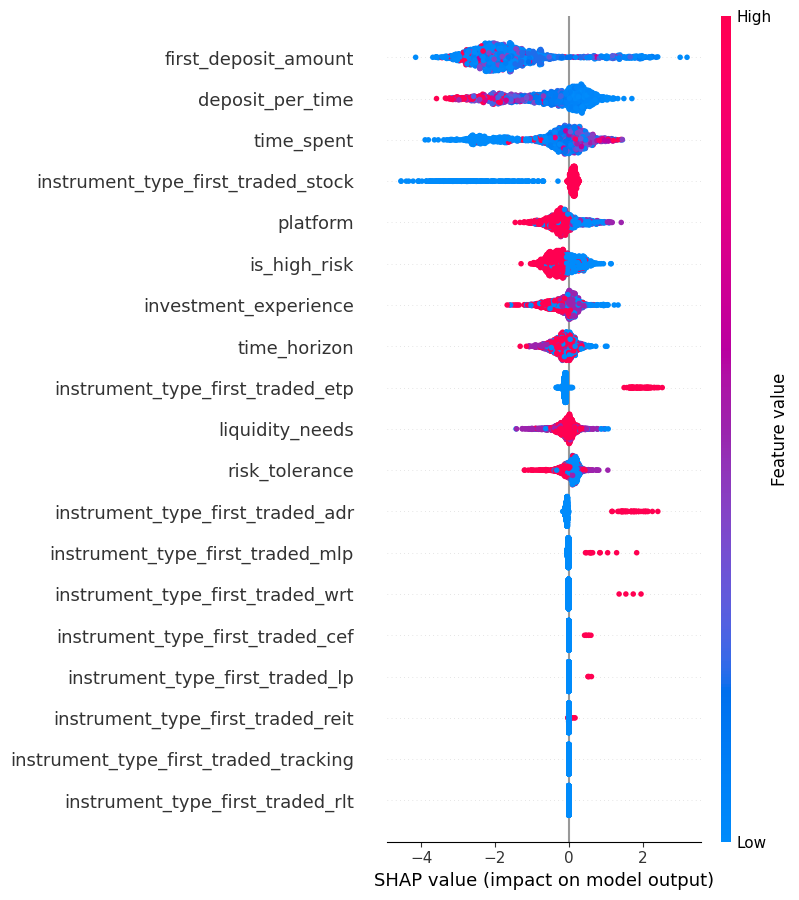

In [9]:
# SHAP for feature importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


### Step 6: Visualization

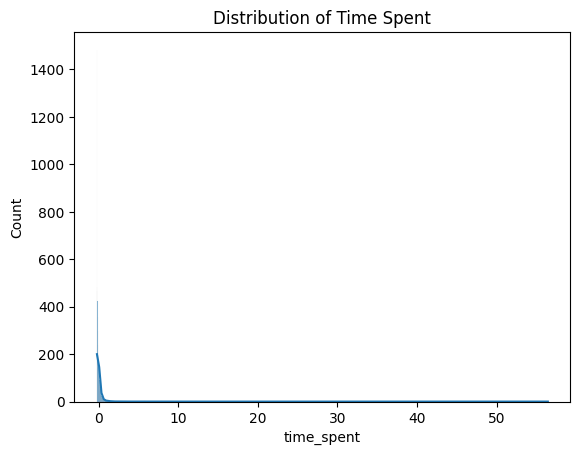

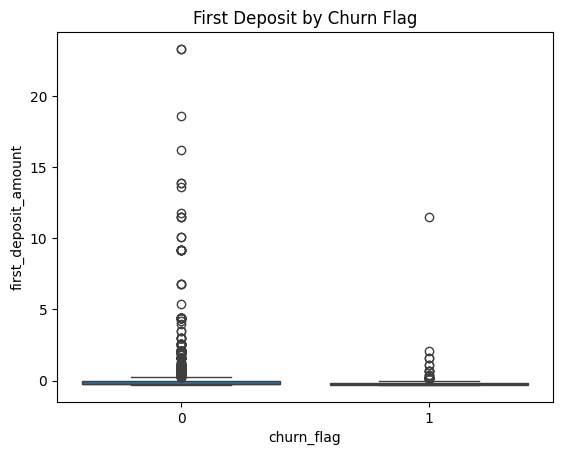

In [10]:
# Distribution of time spent
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent')
plt.show()

# Boxplot of first deposit amount by churn flag
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit by Churn Flag')
plt.show()

### Step 6: Model Explainability with SHAP

c:\Users\cheng\Workspace\robinhood_classifer\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


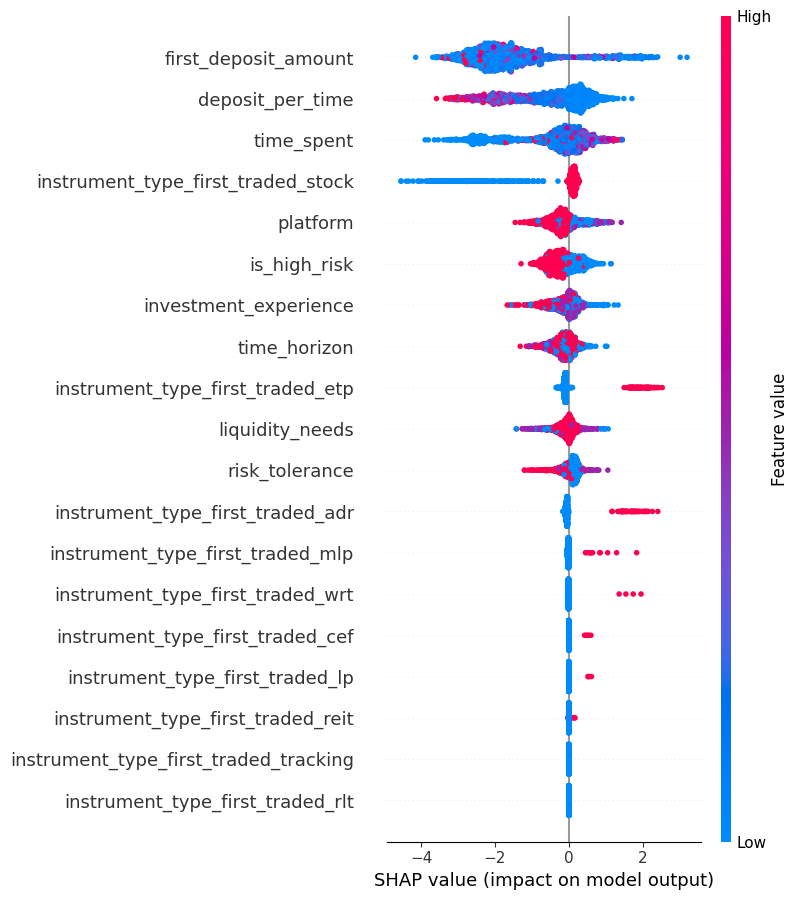

In [11]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


## EDA

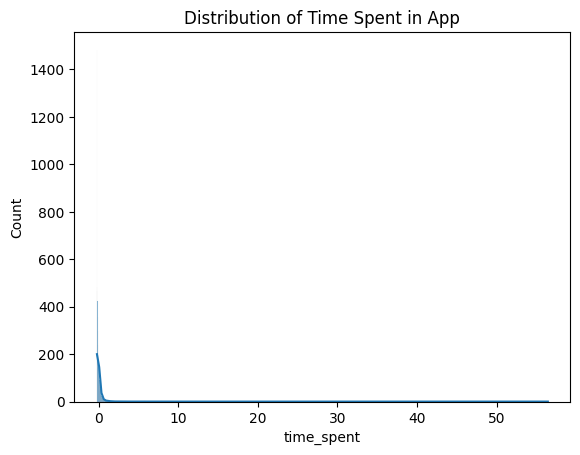

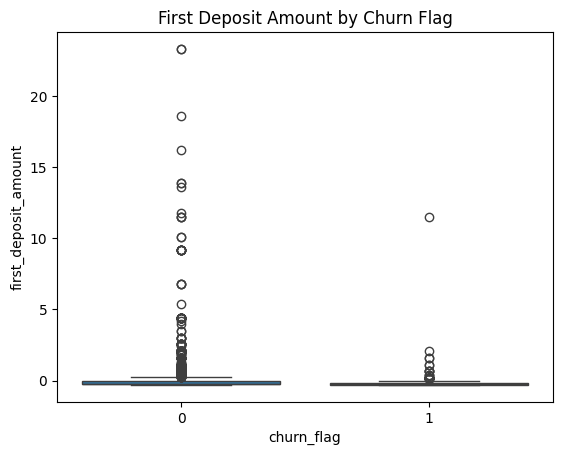

In [12]:
# Distribution of Numerical Features:
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit Amount by Churn Flag')
plt.show()


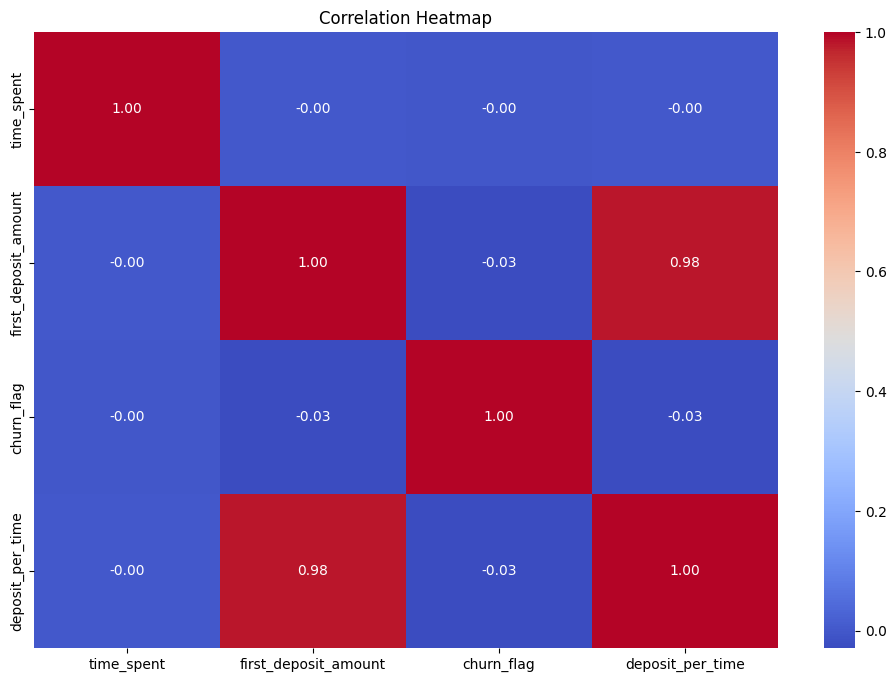

In [13]:
# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

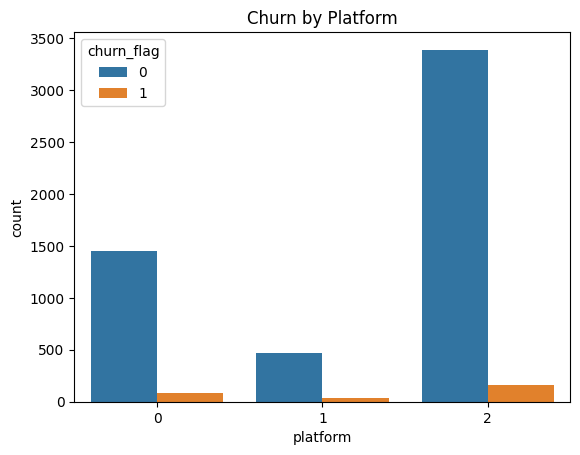

In [14]:
# categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()
